In [1]:
import tensorflow as tf
import os
from PIL import Image
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

In [2]:
dim = 64

In [3]:
def image_gen(path, batch_size):
    img_names = os.listdir(path)
    imgs = []
    shuffle(img_names)
    while True:
        for img_name in img_names:
            img = Image.open(path + '/' + img_name)
            img = img.crop((0, 30, 178, 208)).resize((dim, dim))
            img = np.array(img, dtype='float32')
            img = img / 255
            imgs.append(img)
            assert not np.any(np.isnan(img))
            if len(imgs) >= batch_size:
                yield imgs
                imgs = []

In [4]:
def ResBlock(data, filters, activation=tf.nn.relu, bn=True, name='resblock'):
    block = tf.layers.conv2d(data, filters, 3, padding='same', activation=activation, name=name+'c1', 
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
    block = tf.layers.conv2d(block, filters, 3, strides=2, padding='same', activation=activation, name=name+'c2',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
    if bn:
        block = tf.layers.batch_normalization(block, name=name+'bn')
    ident = tf.layers.conv2d(data, filters, 1, strides=2, padding='same', name=name+'ident')
    block = tf.add(ident, block, name=name+'add')
    return block

In [5]:
def Generator(z):
    with tf.variable_scope('Generator') as scope:
        gen = tf.layers.dense(z, 4*4*512, activation=tf.nn.relu)
        gen = tf.reshape(gen, (-1, 4, 4, 512))
        gen = tf.layers.conv2d_transpose(gen, 256, 3, strides=2, kernel_initializer=tf.random_normal_initializer(0, 0.02),
                                         padding='same', activation=tf.nn.relu, name='ct1',)
        gen = tf.layers.conv2d_transpose(gen, 128, 3, strides=2, kernel_initializer=tf.random_normal_initializer(0, 0.02),
                                         padding='same', activation=tf.nn.relu, name='ct2')
        gen = tf.layers.conv2d_transpose(gen, 32, 3, strides=2, kernel_initializer=tf.random_normal_initializer(0, 0.02),
                                         padding='same', activation=tf.nn.relu, name='ct3')
        gen = tf.layers.conv2d_transpose(gen, 3, 3, strides=2, kernel_initializer=tf.random_normal_initializer(0, 0.02),
                                         padding='same', activation=tf.nn.sigmoid, name='ct4')
    return gen

In [6]:
def Discriminator(images, reuse=False):
    with tf.variable_scope('Discriminator') as scope:
        if reuse:
            scope.reuse_variables()
        desc = ResBlock(images, 64, name='block1')
        desc = ResBlock(desc, 128, name='block2')
        desc = ResBlock(desc, 256, name='block3')
        desc = tf.reshape(desc, (batch_size, -1))
        desc = tf.layers.dense(desc, 50, activation=tf.nn.relu)
        desc = tf.layers.dense(desc, 1, activation=None)
    return desc

In [7]:
gp = tf.constant(5.)
n_critic = 5
lr = 0.0001
batch_size = 64
beta1 = 0.
beta2 = 0.9
epochs = 500
batches = int(202602 / batch_size / n_critic)

In [8]:
with tf.device('/gpu:0'):
    x = tf.placeholder(tf.float32, shape=(batch_size,dim,dim,3))
    z = tf.placeholder(tf.float32, shape=(batch_size,200))
    x_tilda = Generator(z)

    epsilon = tf.random_uniform([1],maxval=1.,minval=0.)
    x_hat = (1 - epsilon) * x + (x_tilda * epsilon)

    disc_x = Discriminator(x)
    disc_x_tilda = Discriminator(x_tilda, reuse=True)

    disc_x_hat = Discriminator(x_hat, reuse=True)

    grad = tf.gradients(disc_x_hat, [x_hat,])[0]
    grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1,2,3]))
    w_loss = tf.reduce_mean(disc_x_tilda - disc_x + gp*(tf.square(grad_norm-1)))

    th_loss = -disc_x_tilda

    d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')
    g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
    train_step_w = tf.train.AdamOptimizer(lr, beta1=beta1, beta2=beta2).minimize(w_loss, var_list=d_vars)
    train_step_th = tf.train.AdamOptimizer(lr, beta1=beta1, beta2=beta2).minimize(th_loss, var_list=g_vars)

In [9]:
config = tf.ConfigProto(allow_soft_placement = True)
sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())

In [10]:
# saver = tf.train.import_meta_graph('checkpoints/wgan-6001.meta')
# saver.restore(sess,tf.train.latest_checkpoint('./checkpoints/'))

In [ ]:
th_losses, w_losses = [], []
saver = tf.train.Saver()
for e in range(epochs):
    train_gen = image_gen('data/img_align_celeba', batch_size)
    for b in trange(batches):
        data = next(train_gen)
        for c in range(n_critic):
            z_val = np.random.uniform(0., 1., (batch_size, 200))
            _, w_loss_val = sess.run([train_step_w, w_loss], {x: next(train_gen), z: z_val})
            w_losses.append(w_loss_val)
        z_val = np.random.uniform(0., 1., (batch_size, 200))
        _, th_loss_val = sess.run([train_step_th, th_loss], {z: z_val})
        th_losses.append(th_loss_val)
    saver.save(sess, 'checkpoints/wgan', global_step=e)
#             tqdm.write('loss ' + str(sum(th_losses[-25:]) / 25) + ' ' + str(sum(w_losses[-25:]) / 25))

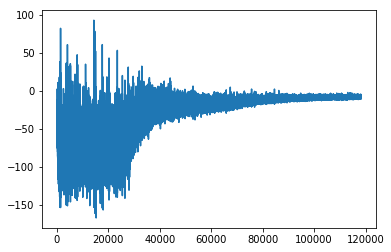

In [140]:
plt.plot(w_losses)
plt.show()

In [126]:
def interpolated():
    res = []
    for j in range(8):
        z1 = np.random.uniform(0., 1., 200)
        z2 = np.random.uniform(0., 1., 200)
        distance = z2 - z1
        for i in range(8):
            res.append(z1 + (i / 7) * distance)
    return np.array(res)

In [130]:
def plot(imgs):
    plt.figure(figsize=(13.9,16))
    columns = 8
    for i, image in enumerate(imgs):
        plt.subplot(len(sample) / columns + 1, columns, i + 1)
        fig = plt.imshow(image, interpolation='nearest')
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

## Random Faces
Sixty four randomly generated faces

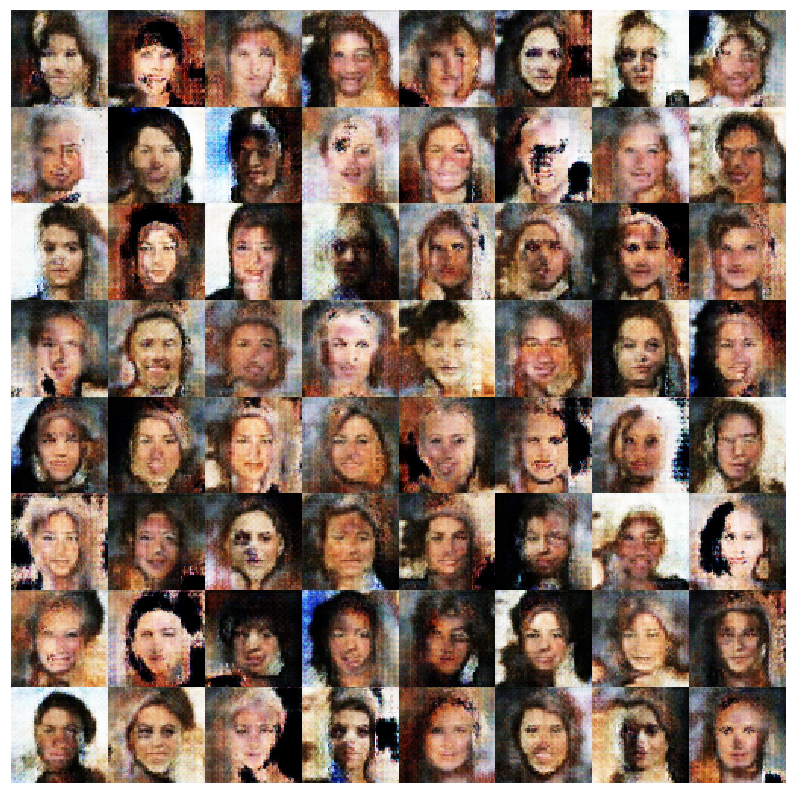

In [145]:
z_val = np.random.uniform(0., 1., (batch_size, 200))
sample = sess.run(x_tilda, {z: z_val})
plot(sample)

## Face Interpolation
Sixteen randomly selected faces and seven interpolation steps between each (left to right)

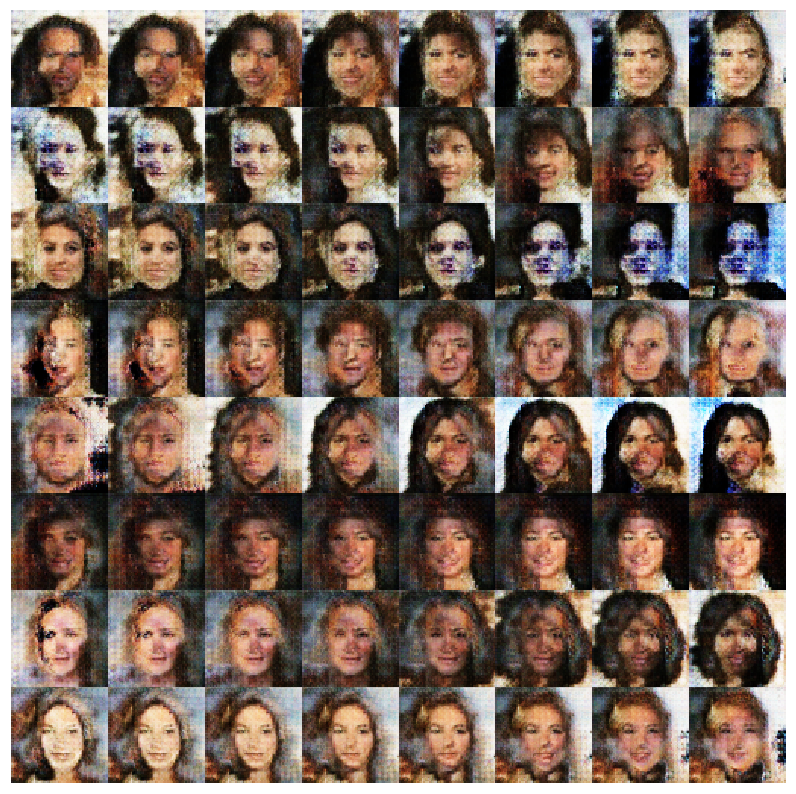

In [141]:
inter = sess.run(x_tilda, {z: interpolated()})
plot(inter)

In [ ]:
writer = tf.summary.FileWriter("viz", sess.graph)
writer.close()